In [1]:
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
from copy import deepcopy
from matplotlib import ticker as mticker

In [2]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

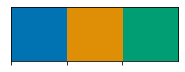

In [3]:
# The colors later used for plot
current_palette = sns.color_palette('colorblind')[:3]
sns.palplot(current_palette)

  0%|          | 0/3 [00:00<?, ?it/s]

finish loading


 33%|███▎      | 1/3 [05:25<10:51, 325.50s/it]

finish loading


 67%|██████▋   | 2/3 [09:55<04:52, 292.96s/it]

finish loading


100%|██████████| 3/3 [13:58<00:00, 279.57s/it]


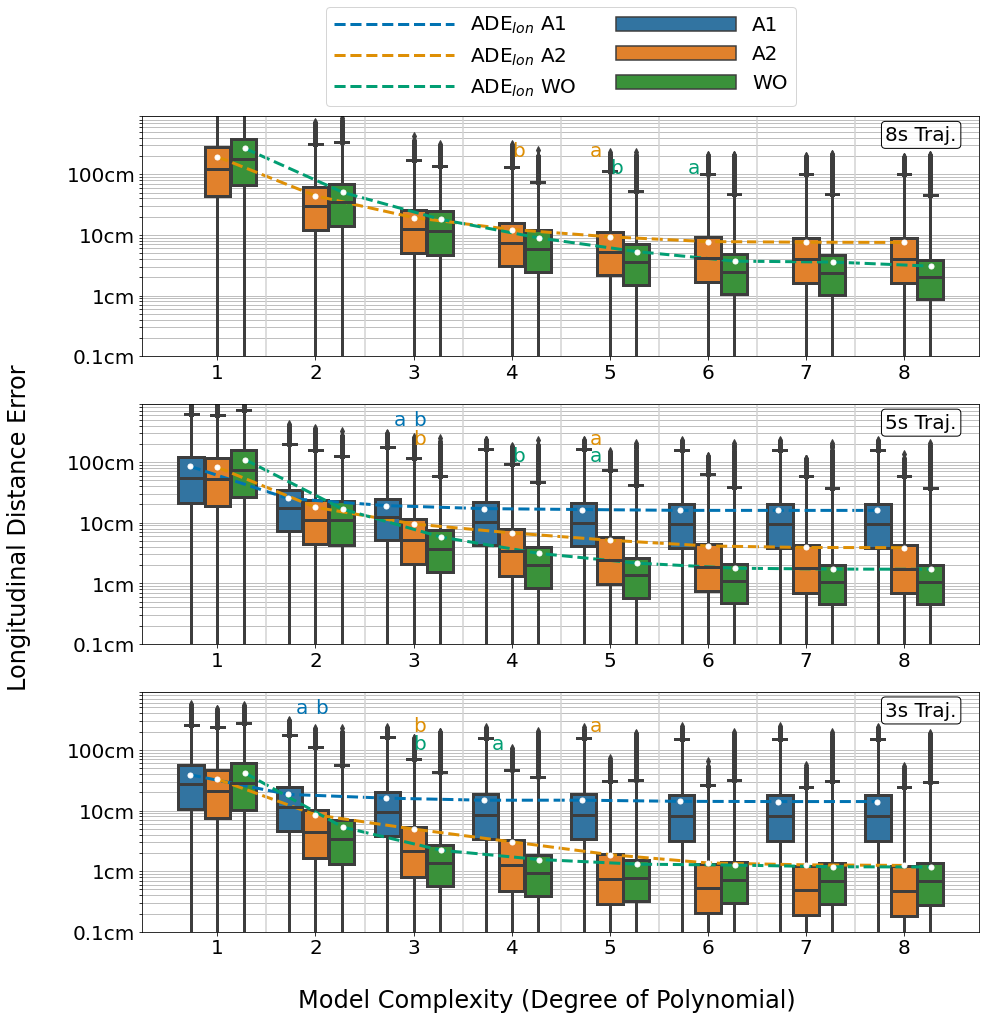

In [4]:
data_name_1 = 'argo1'
data_name_2 = 'argo2'
data_name_3 = 'waymo'
metric_type = 'gt_poly_lon'
fig_name = 'Longitudinal Positional Fitting Error Compared to Measurement'
nums_points_in_one_traj = [80, 50, 30] #[90, 80, 70, 60, 50, 40, 30, 20, 10]
x_ticklabels = ['1', '2', '3', '4', '5', '6', '7', '8']

tick_range = [x for p in [-3, -2, -1, 0] for x in np.linspace(10 ** p, 9 * 10 ** p, 9)]

y_ticklabels = []
for p in ['0.1cm', '1cm', '10cm', '100cm']:
    for i in range(9):
        if i == 0:
            y_ticklabels.append(p)
        else:
            y_ticklabels.append('')

#fig1, axs = plt.subplots(len(nums_points_in_one_traj), 1, figsize = (15, 45))
fig1, axs = plt.subplots(len(nums_points_in_one_traj), 1, figsize = (15, 15))
#fig1.suptitle(fig_name, y=0.92)
fig1.supxlabel('Model Complexity (Degree of Polynomial)', y=0.05)
fig1.supylabel('Longitudinal Distance Error', x = 0)
for idx, num_points in enumerate(tqdm(nums_points_in_one_traj)):
    ax = axs[idx]
    if num_points < 51:
        with open('results/agt_pos_error_polar_' + data_name_1 + '/' + str(num_points) + '/' + metric_type + '.json', "r") as read_file:
            data_1 = np.array(json.load(read_file)) # keep it as list for visualization
            data_1 = (data_1[:, ::7]+ 1e-10)
    else:
        data_1 = np.zeros((8,100)) + 1e-10
    
    with open('results/agt_pos_error_polar_' + data_name_2 + '/vehicle/' + str(num_points) + '/' + metric_type + '.json', "r") as read_file:
        data_2 = np.array(json.load(read_file)) # keep it as list for visualization
        data_2 = (data_2[:, ::7]+ 1e-10).reshape(8, -1)
        
    with open('results/agt_pos_error_polar_' + data_name_3 + '/vehicle/' + str(num_points+1) + '/' + metric_type + '.json', "r") as read_file:
        data_3 = np.array(json.load(read_file)) # keep it as list for visualization
        data_3 = (data_3[:, ::7]+ 1e-10).reshape(8, -1)
    
    d = {'deg': [], 'error': [], 'type': []}
    
    for deg, (d1, d2, d3) in enumerate(zip(data_1, data_2, data_3)):
        for dd1 in d1:
            d['deg'].append(deg+1)
            d['error'].append(np.log10(dd1))
            d['type'].append('A1')
            
        for dd2 in d2:
            d['deg'].append(deg+1)
            d['error'].append(np.log10(dd2))
            d['type'].append('A2') 
            
        for dd3 in d3:
            d['deg'].append(deg+1)
            d['error'].append(np.log10(dd3))
            d['type'].append('WO')
    
    test_data = pd.DataFrame(data=d)
    
    if num_points < 51:
        with open('results/agt_pos_error_polar_' + data_name_1 + '/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
            result_argo1 = json.load(read_file)
        best_agro1_AIC_idx = result_argo1['best_aic_deg_idx']
        best_agro1_BIC_idx = result_argo1['best_bic_deg_idx']
                
    with open('results/agt_pos_error_polar_' + data_name_2 + '/vehicle/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
         result_argo2 = json.load(read_file)
    best_agro2_AIC_idx = result_argo2['best_aic_deg_idx']
    best_agro2_BIC_idx = result_argo2['best_bic_deg_idx']
            
    with open('results/agt_pos_error_polar_' + data_name_3 + '/vehicle/' + str(num_points+1) + '/' + 'result_summary.json', "r")as read_file:
         result_waymo = json.load(read_file)
    best_waymo_AIC_idx = result_waymo['best_aic_deg_idx']
    best_waymo_BIC_idx = result_waymo['best_bic_deg_idx']
    print('finish loading')
    
    
    
    ax = sns.boxplot(x = test_data.deg, y = test_data.error,  hue=test_data.type, data = test_data, ax=ax, linewidth = 3, whis=[0, 99.9])
    ax.plot(np.array(range(8)) - 0.28, np.log10(np.mean(data_1,axis = 1)), '--' , color=current_palette[0], linewidth = 3, label = 'ADE$_{lon}$ A1')
    ax.plot(np.array(range(8)), np.log10(np.mean(data_2,axis = 1)), '--' , color=current_palette[1], linewidth = 3, label = 'ADE$_{lon}$ A2')
    ax.plot(np.array(range(8)) + 0.28, np.log10(np.mean(data_3,axis = 1)), '--' , color=current_palette[2], linewidth = 3, label = 'ADE$_{lon}$ WO')
    
    ax.plot(np.array(range(8)) - 0.28, np.log10(np.mean(data_1,axis = 1)), 'wo', markersize = 5)
    ax.plot(np.array(range(8)), np.log10(np.mean(data_2,axis = 1)), 'wo', markersize = 5)
    ax.plot(np.array(range(8)) + 0.28, np.log10(np.mean(data_3,axis = 1)), 'wo', markersize = 5)
    if idx == 0:
        ax.legend(fontsize = 20, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1), handlelength= 6)
    else:
        ax.get_legend().remove()
        
        
    for x in np.linspace(0.5, 6.5, 7):
        ax.axvline(x=x, color = 'lightgrey')    
        
    ax.annotate(str(int(num_points/10)) + 's Traj.',
            xy = (0.888, 0.9),
            xycoords='axes fraction',
            bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black', boxstyle='round,pad=0.2'))
    
    
    
    if num_points < 51:
        ax.annotate('a', fontsize= 20, color=current_palette[0],xy = (best_agro1_AIC_idx-0.2, 0.6))
        ax.annotate('b', fontsize= 20, color=current_palette[0], xy = (best_agro1_BIC_idx, 0.6))
    
    ax.annotate('a', fontsize= 20, color=current_palette[1], xy = (best_agro2_AIC_idx-0.2, 0.3))
    ax.annotate('b', fontsize= 20, color=current_palette[1], xy = (best_agro2_BIC_idx, 0.3))
    
    ax.annotate('a', fontsize= 20, color=current_palette[2], xy = (best_waymo_AIC_idx-0.2, 0.01))
    ax.annotate('b', fontsize= 20, color=current_palette[2], xy = (best_waymo_BIC_idx, 0.01))
    
    ax.set_xticklabels(x_ticklabels)
    ax.set_xlabel('')
    ax.set_ylim([np.log10(1e-3), np.log10(1e0)])
    ax.set_ylabel('')
    ax.set_yticks(np.log10(tick_range))
    ax.set_yticklabels(y_ticklabels)
    ax.grid(True, axis = 'y', zorder=-100)
    ax.set_axisbelow(True)
    ax.plot()

In [6]:
fig1.savefig('imgs/MAE_summary_lon_mean_358_new.pdf', dpi=300, format='pdf', bbox_inches='tight')
fig1.savefig('imgs/MAE_summary_lon_mean_358_new.jpg', dpi=300, format='jpg', bbox_inches='tight')
fig1.savefig('imgs/MAE_summary_lon_mean_358_new.svg', dpi=300, format='svg', bbox_inches='tight')

  0%|          | 0/3 [00:00<?, ?it/s]

finish loading


 33%|███▎      | 1/3 [01:51<03:42, 111.22s/it]

finish loading


 67%|██████▋   | 2/3 [03:02<01:28, 88.01s/it] 

finish loading


100%|██████████| 3/3 [03:44<00:00, 74.83s/it]


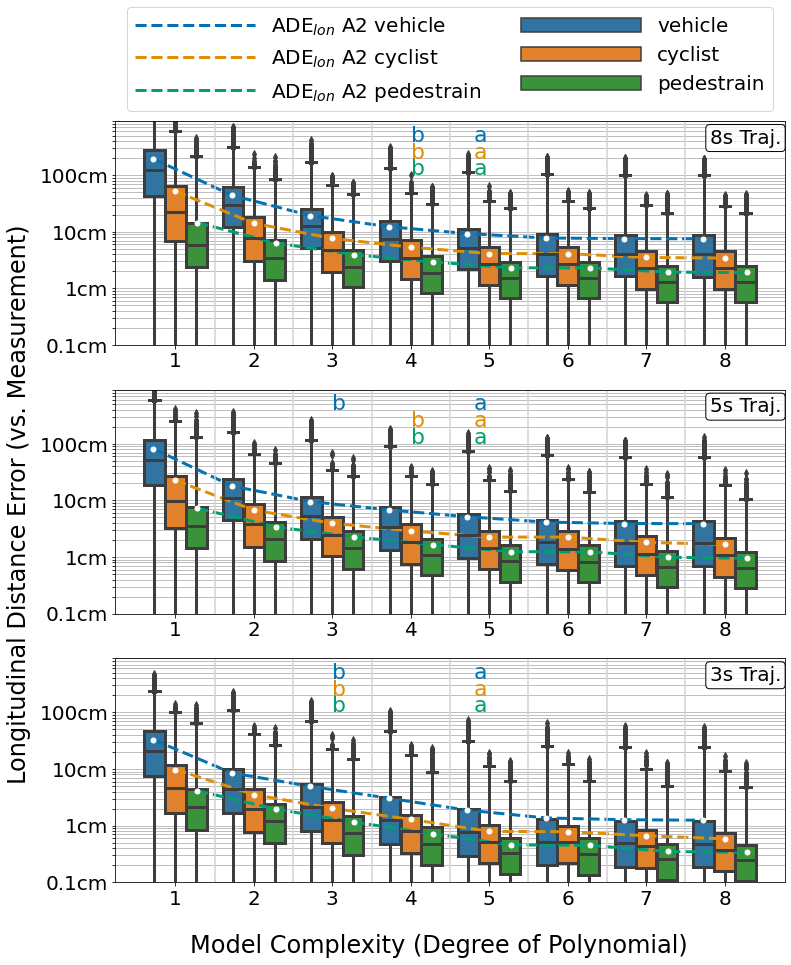

In [10]:
dataset = 'argo2'
data_name_1 = 'vehicle'
data_name_2 = 'cyclist'
data_name_3 = 'pedestrain'
metric_type = 'gt_poly_lon'
fig_name = 'Longitudinal Positional Fitting Error Compared to Measurement'
nums_points_in_one_traj = [80, 50, 30] #[90, 80, 70, 60, 50, 40, 30, 20, 10]
x_ticklabels = ['1', '2', '3', '4', '5', '6', '7', '8']

tick_range = [x for p in [-3, -2, -1, 0] for x in np.linspace(10 ** p, 9 * 10 ** p, 9)]

y_ticklabels = []
for p in ['0.1cm', '1cm', '10cm', '100cm']:
    for i in range(9):
        if i == 0:
            y_ticklabels.append(p)
        else:
            y_ticklabels.append('')

#fig1, axs = plt.subplots(len(nums_points_in_one_traj), 1, figsize = (15, 45))
fig1, axs = plt.subplots(len(nums_points_in_one_traj), 1, figsize = (12, 14))
#fig1.suptitle(fig_name, y=0.92)
fig1.supxlabel('Model Complexity (Degree of Polynomial)', y=0.05)
fig1.supylabel('Longitudinal Distance Error (vs. Measurement)', x = 0)
for idx, num_points in enumerate(tqdm(nums_points_in_one_traj)):
    ax = axs[idx]

    with open('results/agt_pos_error_polar_' + dataset+ '/' + data_name_1 + '/' + str(num_points) + '/' + metric_type + '.json', "r") as read_file:
        data_1 = np.array(json.load(read_file)) # keep it as list for visualization
        data_1 = (data_1[:, ::7]+ 1e-10).reshape(8, -1)

    
    with open('results/agt_pos_error_polar_' + dataset + '/' + data_name_2 + '/' + str(num_points) + '/' + metric_type + '.json', "r") as read_file:
        data_2 = np.array(json.load(read_file)) # keep it as list for visualization
        data_2 = (data_2[:, ::7]+ 1e-10).reshape(8, -1)
        
    with open('results/agt_pos_error_polar_' + dataset + '/' + data_name_3 + '/' + str(num_points) + '/' + metric_type + '.json', "r") as read_file:
        data_3 = np.array(json.load(read_file)) # keep it as list for visualization
        data_3 = (data_3[:, ::7]+ 1e-10).reshape(8, -1)
    
    d = {'deg': [], 'error': [], 'type': []}
    
    
    for deg, (d1, d2, d3) in enumerate(zip(data_1, data_2, data_3)):
        for dd1 in d1:
            d['deg'].append(deg+1)
            d['error'].append(np.log10(dd1))
            d['type'].append(data_name_1)
            
        for dd2 in d2:
            d['deg'].append(deg+1)
            d['error'].append(np.log10(dd2))
            d['type'].append(data_name_2) 
            
        for dd3 in d3:
            d['deg'].append(deg+1)
            d['error'].append(np.log10(dd3))
            d['type'].append(data_name_3)
    
    test_data = pd.DataFrame(data=d)
    
    
    with open('results/agt_pos_error_polar_' + dataset+ '/'+ data_name_1 + '/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
        result_argo1 = json.load(read_file)
    best_agro1_AIC_idx = result_argo1['best_aic_deg_idx']
    best_agro1_BIC_idx = result_argo1['best_bic_deg_idx']
                
    with open('results/agt_pos_error_polar_' + dataset+ '/'+ data_name_2 + '/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
         result_argo2 = json.load(read_file)
    best_agro2_AIC_idx = result_argo2['best_aic_deg_idx']
    best_agro2_BIC_idx = result_argo2['best_bic_deg_idx']
            
    with open('results/agt_pos_error_polar_' + dataset+ '/'+ data_name_3 + '/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
         result_waymo = json.load(read_file)
    best_waymo_AIC_idx = result_waymo['best_aic_deg_idx']
    best_waymo_BIC_idx = result_waymo['best_bic_deg_idx']
    print('finish loading')
    
    
    
    ax = sns.boxplot(x = test_data.deg, y = test_data.error,  hue=test_data.type, data = test_data, ax=ax, linewidth = 3, whis=[0, 99.9])
    ax.plot(np.array(range(8)) - 0.28, np.log10(np.mean(data_1,axis = 1)), '--' , color=current_palette[0], linewidth = 3, label = 'ADE$_{lon}$ A2 ' + data_name_1)
    ax.plot(np.array(range(8)), np.log10(np.mean(data_2,axis = 1)), '--' , color=current_palette[1], linewidth = 3, label = 'ADE$_{lon}$ A2 ' + data_name_2)
    ax.plot(np.array(range(8)) + 0.28, np.log10(np.mean(data_3,axis = 1)), '--' , color=current_palette[2], linewidth = 3, label = 'ADE$_{lon}$ A2 ' + data_name_3)
    
    ax.plot(np.array(range(8)) - 0.28, np.log10(np.mean(data_1,axis = 1)), 'wo', markersize = 5)
    ax.plot(np.array(range(8)), np.log10(np.mean(data_2,axis = 1)), 'wo', markersize = 5)
    ax.plot(np.array(range(8)) + 0.28, np.log10(np.mean(data_3,axis = 1)), 'wo', markersize = 5)
    if idx == 0:
        ax.legend(fontsize = 20, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1), handlelength= 6)
    else:
        ax.get_legend().remove()
            
            
    for x in np.linspace(0.5, 6.5, 7):
        ax.axvline(x=x, color = 'lightgrey')
    
    ax.annotate(str(int(num_points/10)) + 's Traj.',
            xy = (0.888, 0.9),
            xycoords='axes fraction',
            bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black', boxstyle='round,pad=0.2'))

    ax.annotate('a', fontsize= 22, color=current_palette[0],xy = (best_agro1_AIC_idx-0.2, 0.6))
    ax.annotate('b', fontsize= 22, color=current_palette[0], xy = (best_agro1_BIC_idx, 0.6))
    
    ax.annotate('a', fontsize= 22, color=current_palette[1], xy = (best_agro2_AIC_idx-0.2, 0.3))
    ax.annotate('b', fontsize= 22, color=current_palette[1], xy = (best_agro2_BIC_idx, 0.3))
    
    ax.annotate('a', fontsize= 22, color=current_palette[2], xy = (best_waymo_AIC_idx-0.2, 0.01))
    ax.annotate('b', fontsize= 22, color=current_palette[2], xy = (best_waymo_BIC_idx, 0.01))
    
    ax.set_xticklabels(x_ticklabels)
    ax.set_xlabel('')
    ax.set_ylim([np.log10(1e-3), np.log10(1e0)])
    ax.set_ylabel('')
    ax.set_yticks(np.log10(tick_range))
    ax.set_yticklabels(y_ticklabels)
    ax.grid(True, axis = 'y', zorder=-100)
    ax.set_axisbelow(True)
    ax.plot()

In [11]:
fig1.savefig('imgs/MAE_summary_lon_mean_358_'+ dataset+'.pdf', dpi=300, format='pdf', bbox_inches='tight')
fig1.savefig('imgs/MAE_summary_lon_mean_358_'+ dataset+'.jpg', dpi=300, format='jpg', bbox_inches='tight')
fig1.savefig('imgs/MAE_summary_lon_mean_358_'+ dataset+'.svg', dpi=300, format='svg', bbox_inches='tight')

  0%|          | 0/3 [00:00<?, ?it/s]

finish loading


 33%|███▎      | 1/3 [00:00<00:01,  1.63it/s]

finish loading


 67%|██████▋   | 2/3 [00:00<00:00,  2.56it/s]

finish loading


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


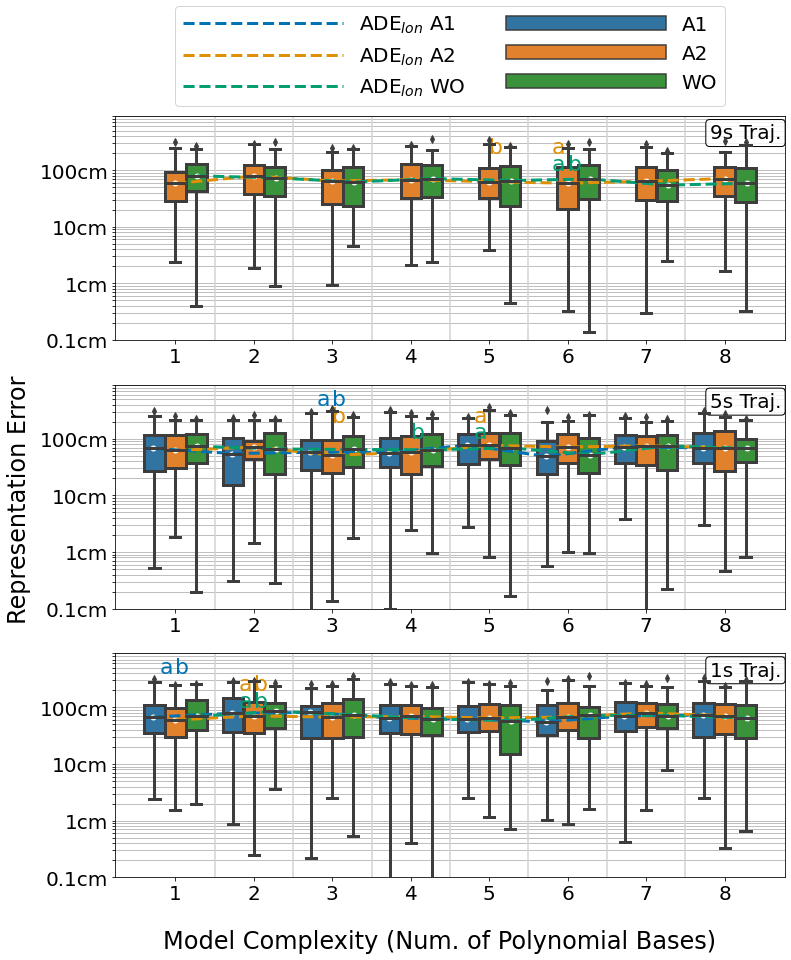

In [13]:
data_name_1 = 'argo1'
data_name_2 = 'argo2'
data_name_3 = 'waymo'
metric_type = 'kf_poly_lon'
fig_name = 'Longitudinal Positional Fitting Error Compared to Measurement'
nums_points_in_one_traj = [90, 50, 10]# [90, 80, 70, 60, 50, 40, 30, 20, 10]
x_ticklabels = ['1', '2', '3', '4', '5', '6', '7', '8']

tick_range = [x for p in [-3, -2, -1, 0] for x in np.linspace(10 ** p, 9 * 10 ** p, 9)]

y_ticklabels = []
for p in ['0.1cm', '1cm', '10cm', '100cm']:
    for i in range(9):
        if i == 0:
            y_ticklabels.append(p)
        else:
            y_ticklabels.append('')

fig1, axs = plt.subplots(len(nums_points_in_one_traj), 1, figsize = (12, 14))
#fig1.suptitle(fig_name, y=0.92)
fig1.supxlabel('Model Complexity (Num. of Polynomial Bases)', y=0.05)
fig1.supylabel('Representation Error', x = 0)
for idx, num_points in enumerate(tqdm(nums_points_in_one_traj)):
    ax = axs[idx]
    if num_points < 51:
            data_1 = np.log10(np.abs(np.random.randn(8, 100))) 
    else:
        data_1 = np.log10(np.zeros((8,100)) + 1e-10)
    
    data_2 = np.log10(np.abs(np.random.randn(8, 100))) 
        
    data_3 = np.log10(np.abs(np.random.randn(8, 100))) 
    
    d = {'deg': [], 'error': [], 'type': []}
    
    for deg, (d1, d2, d3) in enumerate(zip(data_1, data_2, data_3)):
        for dd1 in d1:
            d['deg'].append(deg+1)
            d['error'].append(dd1)
            d['type'].append('A1')
            
        for dd2 in d2:
            d['deg'].append(deg+1)
            d['error'].append(dd2)
            d['type'].append('A2') 
            
        for dd3 in d3:
            d['deg'].append(deg+1)
            d['error'].append(dd3)
            d['type'].append('WO')
    
    test_data = pd.DataFrame(data=d)
    
    if num_points < 51:
        with open('results/agt_pos_error_polar_' + data_name_1 + '/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
            result_argo1 = json.load(read_file)
        best_agro1_AIC_idx = result_argo1['best_aic_deg_idx']
        best_agro1_BIC_idx = result_argo1['best_bic_deg_idx']
                
    with open('results/agt_pos_error_polar_' + data_name_2 + '/vehicle/' + str(num_points) + '/' + 'result_summary.json', "r")as read_file:
         result_argo2 = json.load(read_file)
    best_agro2_AIC_idx = result_argo2['best_aic_deg_idx']
    best_agro2_BIC_idx = result_argo2['best_bic_deg_idx']
            
    with open('results/agt_pos_error_polar_' + data_name_3 + '/vehicle/' + str(num_points+1) + '/' + 'result_summary.json', "r")as read_file:
         result_waymo = json.load(read_file)
    best_waymo_AIC_idx = result_waymo['best_aic_deg_idx']
    best_waymo_BIC_idx = result_waymo['best_bic_deg_idx']
    print('finish loading')
    
    
    
    ax = sns.boxplot(x = test_data.deg, y = test_data.error,  hue=test_data.type, data = test_data, ax=ax, linewidth = 3, whis=[0, 99.9], zorder=100)
    ax.plot(np.array(range(8)) - 0.28, np.median(data_1,axis = 1), '--' , color=current_palette[0], linewidth = 3, label = 'ADE$_{lon}$ A1', zorder= 10)
    ax.plot(np.array(range(8)), np.median(data_2,axis = 1), '--' , color=current_palette[1], linewidth = 3, label = 'ADE$_{lon}$ A2', zorder= 10)
    ax.plot(np.array(range(8)) + 0.28, np.median(data_3,axis = 1), '--' , color=current_palette[2], linewidth = 3, label = 'ADE$_{lon}$ WO', zorder= 10)
    
    ax.plot(np.array(range(8)) - 0.28, np.median(data_1,axis = 1), 'wo', markersize = 5)
    ax.plot(np.array(range(8)), np.median(data_2,axis = 1), 'wo', markersize = 5)
    ax.plot(np.array(range(8)) + 0.28, np.median(data_3,axis = 1), 'wo', markersize = 5)
    

    for x in np.linspace(0.5, 6.5, 7):
        ax.axvline(x=x, color = 'lightgrey')
    
    if idx == 0:
        ax.legend(fontsize = 20, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1), handlelength= 8)
    else:
        ax.get_legend().remove()
        
    ax.annotate(str(int(num_points/10)) + 's Traj.',
            xy = (0.888, 0.9),
            xycoords='axes fraction',
            bbox=dict(facecolor=(1, 1, 1, 0.8), edgecolor='black', boxstyle='round,pad=0.2'))
    
    if num_points < 51:
        ax.annotate('a', fontsize= 22, color=current_palette[0],xy = (best_agro1_AIC_idx-0.2, 0.6))
        ax.annotate('b', fontsize= 22, color=current_palette[0], xy = (best_agro1_BIC_idx, 0.6))
    
    ax.annotate('a', fontsize= 22, color=current_palette[1], xy = (best_agro2_AIC_idx-0.2, 0.3))
    ax.annotate('b', fontsize= 22, color=current_palette[1], xy = (best_agro2_BIC_idx, 0.3))
    
    ax.annotate('a', fontsize= 22, color=current_palette[2], xy = (best_waymo_AIC_idx-0.2, 0.01))
    ax.annotate('b', fontsize= 22, color=current_palette[2], xy = (best_waymo_BIC_idx, 0.01))
    
    ax.set_xticklabels(x_ticklabels)
    ax.set_xlabel('')
    ax.set_ylim([np.log10(1e-3), np.log10(1e0)])
    ax.set_ylabel('')
    ax.set_yticks(np.log10(tick_range))
    ax.set_yticklabels(y_ticklabels)
    ax.grid(True, axis = 'y', zorder=-100)
    ax.set_axisbelow(True)
    ax.plot()